In [ ]:
import tensorflow as tf
tf.random.set_seed(1)
tf.compat.v1.enable_eager_execution()

import numpy as np
np.random.seed(1)

import gensim
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, \
    SpatialDropout1D, Bidirectional, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

%matplotlib inline

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
df = pd.read_csv('../data/data.csv')

In [ ]:
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [ ]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [ ]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [ ]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)

In [ ]:
tags = sorted([t for t in tags if t != 'O'], key=lambda x: (x[2], x[0]))
tags.append('O')

In [ ]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [ ]:
tag2idx

{'B-LOCATION': 0,
 'B-ORGANIZATION': 4,
 'B-PERSON': 8,
 'B-QUANTITY': 12,
 'B-TIME': 16,
 'I-LOCATION': 1,
 'I-ORGANIZATION': 5,
 'I-PERSON': 9,
 'I-QUANTITY': 13,
 'I-TIME': 17,
 'L-LOCATION': 2,
 'L-ORGANIZATION': 6,
 'L-PERSON': 10,
 'L-QUANTITY': 14,
 'L-TIME': 18,
 'O': 20,
 'U-LOCATION': 3,
 'U-ORGANIZATION': 7,
 'U-PERSON': 11,
 'U-QUANTITY': 15,
 'U-TIME': 19}

### Pad Sequence

In [ ]:
max_len = 40
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [ ]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)

### Pre-trained Word2Vec Embedding

In [ ]:
model = gensim.models.Word2Vec.load("../checkpoint/w2vec_wiki_id_case")

In [ ]:
embedding_matrix = np.zeros((len(words), 400))

for i, w in enumerate(words):
    try:
        embedding_vector = model.wv[w]
        embedding_matrix[i] = embedding_vector
    except:
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), 400)

Initial parameters

In [ ]:
params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'filters': [128],
    'filter_size': [3],
    'dropout': 0.1,
    'batch_size': 128
}

In [ ]:
def get_report(model, history):
    # plot loss
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], "-o")
    plt.plot(history.history['val_loss'], "-o")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # plot f1 score
    fig=plt.figure(figsize=(7,5))
    plt.plot(history.history['f1_score_micro'], "-o")
    plt.plot(history.history['val_f1_score_micro'], "-o")
    plt.title('f1_micro')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average include label O:', score)
    
    print()
    # print classification report
    print(classification_report(actuals, preds, target_names=tags, ))
    
    print()
    # f1 score micro average
    actuals = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1).reshape(-1)

    o_pad_idx = np.where(actuals==20)

    actuals = np.delete(actuals, o_pad_idx)
    preds = np.delete(preds, o_pad_idx)

    score = f1_score(actuals, preds, average='micro')

    print('f1 score micro average without label O:', score)
    
    print()
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))

    cm_matrix = confusion_matrix(actuals, preds)
    cm_matrix = np.delete(cm_matrix, (20), axis=0)
    cm_matrix = np.delete(cm_matrix, (20), axis=1)

    ax.matshow(cm_matrix, cmap=plt.cm.Blues)

    for i in range(num_tags-1):
        for j in range(num_tags-1):
            c = cm_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')

    plt.xticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.yticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.xticks(rotation=90)
    plt.show();

In [ ]:
def f1_score_micro(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=-1).reshape(-1)
    y_pred = np.argmax(y_pred.numpy(), axis=-1).reshape(-1)
    
    # label O will be ignored during training and evaluation
    o_pad_idx = np.where(y_true==20) # 20 is the idx for label O
    
    # remove label O
    y_true = np.delete(y_true, o_pad_idx)
    y_pred = np.delete(y_pred, o_pad_idx)
    
    # compute f1 score with micro average
    score = f1_score(y_true, y_pred, average='micro')
    
    return score

In [ ]:
def create_model(params, w2v=False, cnn=False):
    input_sequence = Input(shape=(max_len, ))
    
    # embedding layer
    if w2v:
        model = Embedding(
            input_dim= embedding_matrix.shape[0], 
            weights=[embedding_matrix], 
            output_dim=embedding_matrix.shape[1], 
            input_length=max_len,
            trainable=False
        )(input_sequence)
    else:
        model = Embedding(
            input_dim=num_words,
            output_dim=400,
            input_length=max_len,
        )(input_sequence)
    
    # dropout layer
    model = SpatialDropout1D(0.1)(model)
    
    # convolution layer
    if cnn:
        if len(params['filters']) == 1:
            model = Conv1D(params['filters'][0], params['filter_size'][0], activation='relu', padding='same')(model)
        else:
            cnns = []
            for i, _ in enumerate(params['filters']):
                cnns.append(Conv1D(
                    params['filters'][i], params['filter_size'][i], 
                    activation='relu', padding='same')(model))
            
            model = concatenate(cnns)
            
    # lstm layer
    model = Bidirectional(LSTM(units=100, return_sequences=True))(model)
    
    # output layer
    output_sequence = Dense(num_tags, activation='softmax')(model)
    
    # model
    model = Model(input_sequence, output_sequence)
    
    # learning algorithm (optimizer)
    if params['optimizer'] == 'Nadam':
        optm = tf.keras.optimizers.Nadam(lr=params['lr'])
        
    if params['optimizer'] == 'Adam':
        optm = tf.keras.optimizers.Adam(lr=params['lr'])
        
    if params['optimizer'] == 'RMSprop':
        optm = tf.keras.optimizers.RMSprop(lr=params['lr'])
    
    loss = tf.keras.losses.CategoricalCrossentropy()

    model.compile(loss=loss, optimizer=optm, metrics=[f1_score_micro], run_eagerly=True)
    
    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_f1_score_micro', mode='max')

### BiLSTM

In [ ]:
bilstm = create_model(params)

In [ ]:
bilstm.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 400)           5212400   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 400)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 200)           400800    
_________________________________________________________________
dense (Dense)                (None, 40, 21)            4221      
Total params: 5,617,421
Trainable params: 5,617,421
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time

bilstm_history = bilstm.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 3s 115ms/step - loss: 1.1960 - f1_score_micro: 0.0036 - val_loss: 0.4633 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 3s 112ms/step - loss: 0.4452 - f1_score_micro: 0.0000e+00 - val_loss: 0.4113 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 3s 112ms/step - loss: 0.3846 - f1_score_micro: 0.0000e+00 - val_loss: 0.3652 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 3s 113ms/step - loss: 0.3326 - f1_score_micro: 9.6649e-04 - val_loss: 0.3292 - val_f1_score_micro: 0.0077
Epoch 5/100
27/27 [==============================] - 3s 113ms/step - loss: 0.2918 - f1_score_micro: 0.0403 - val_loss: 0.3066 - val_f1_score_micro: 0.0730
Epoch 6/100
27/27 [==============================] - 3s 115ms/step - loss: 0.2608 - f1_score_micro: 0.1453 - val_loss: 0.2883 - val_f1_score_micro: 0.1684
Epoch 7/100
27/27 [===========================

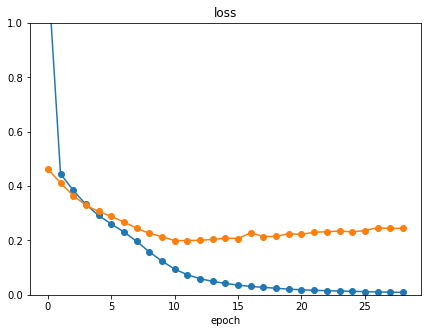

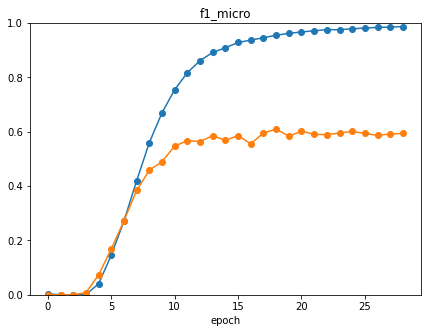


f1 score micro average include label O: 0.9580040871934605

                precision    recall  f1-score   support

    B-LOCATION       0.66      0.55      0.60       103
    I-LOCATION       0.53      0.31      0.39        77
    L-LOCATION       0.71      0.64      0.68       101
    U-LOCATION       0.75      0.70      0.72       235
B-ORGANIZATION       0.68      0.59      0.63       152
I-ORGANIZATION       0.72      0.42      0.53       138
L-ORGANIZATION       0.67      0.59      0.63       155
U-ORGANIZATION       0.78      0.76      0.77       248
      B-PERSON       0.83      0.69      0.76       224
      I-PERSON       0.76      0.58      0.66        60
      L-PERSON       0.85      0.66      0.74       225
      U-PERSON       0.85      0.82      0.83       257
    B-QUANTITY       0.48      0.34      0.40        58
    I-QUANTITY       0.47      0.40      0.43        52
    L-QUANTITY       0.48      0.45      0.47        53
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6022679546409072



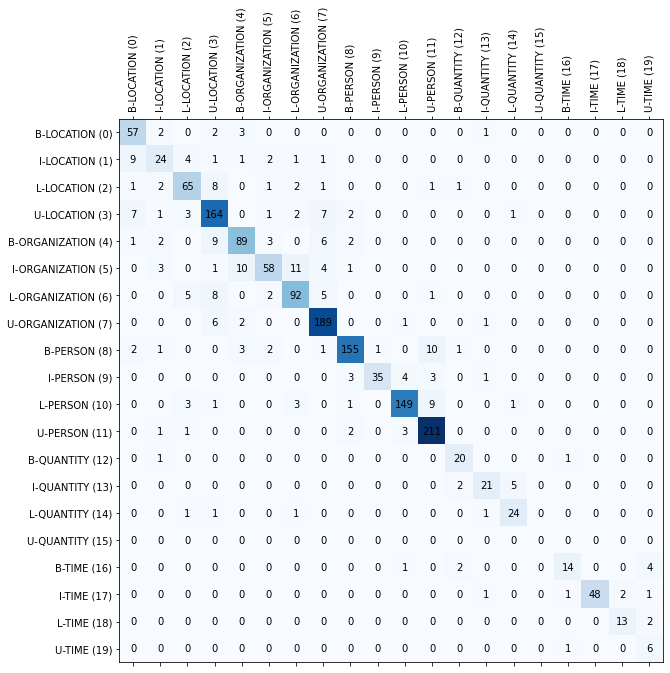

In [ ]:
get_report(bilstm, bilstm_history)

### BiLSTM + w2v

In [ ]:
bilstm_w2v = create_model(params, w2v=True)

In [ ]:
bilstm_w2v.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 400)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 200)           400800    
_________________________________________________________________
dense_1 (Dense)              (None, 40, 21)            4221      
Total params: 5,617,421
Trainable params: 405,021
Non-trainable params: 5,212,400
_________________________________________________________________


In [ ]:
%%time

bilstm_w2v_history = bilstm_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 1s 40ms/step - loss: 0.7649 - f1_score_micro: 0.0025 - val_loss: 0.4470 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 1s 39ms/step - loss: 0.4432 - f1_score_micro: 0.0029 - val_loss: 0.4208 - val_f1_score_micro: 0.0064
Epoch 3/100
27/27 [==============================] - 1s 41ms/step - loss: 0.4190 - f1_score_micro: 0.0055 - val_loss: 0.4011 - val_f1_score_micro: 0.0115
Epoch 4/100
27/27 [==============================] - 1s 39ms/step - loss: 0.3978 - f1_score_micro: 0.0114 - val_loss: 0.3805 - val_f1_score_micro: 0.0222
Epoch 5/100
27/27 [==============================] - 1s 39ms/step - loss: 0.3738 - f1_score_micro: 0.0180 - val_loss: 0.3569 - val_f1_score_micro: 0.0281
Epoch 6/100
27/27 [==============================] - 1s 39ms/step - loss: 0.3471 - f1_score_micro: 0.0281 - val_loss: 0.3323 - val_f1_score_micro: 0.0521
Epoch 7/100
27/27 [==============================] - 1s 39ms/step - loss

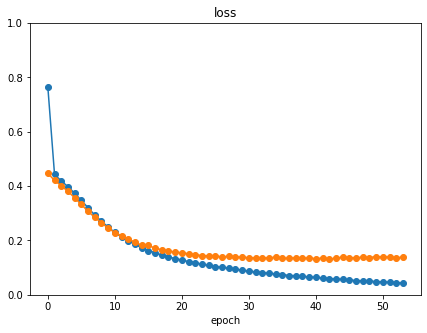

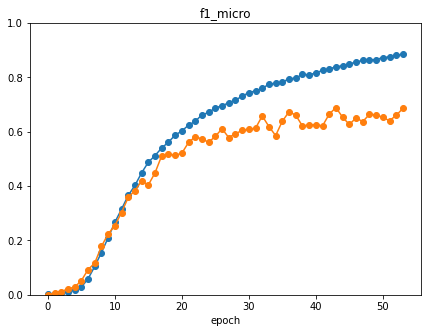


f1 score micro average include label O: 0.9619209809264305

                precision    recall  f1-score   support

    B-LOCATION       0.65      0.64      0.64       103
    I-LOCATION       0.56      0.52      0.54        77
    L-LOCATION       0.71      0.63      0.67       101
    U-LOCATION       0.71      0.82      0.76       235
B-ORGANIZATION       0.64      0.53      0.58       152
I-ORGANIZATION       0.64      0.49      0.55       138
L-ORGANIZATION       0.63      0.57      0.60       155
U-ORGANIZATION       0.74      0.60      0.66       248
      B-PERSON       0.81      0.83      0.82       224
      I-PERSON       0.59      0.60      0.60        60
      L-PERSON       0.87      0.82      0.84       225
      U-PERSON       0.81      0.88      0.84       257
    B-QUANTITY       0.48      0.38      0.42        58
    I-QUANTITY       0.71      0.42      0.53        52
    L-QUANTITY       0.51      0.43      0.47        53
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6770264594708106



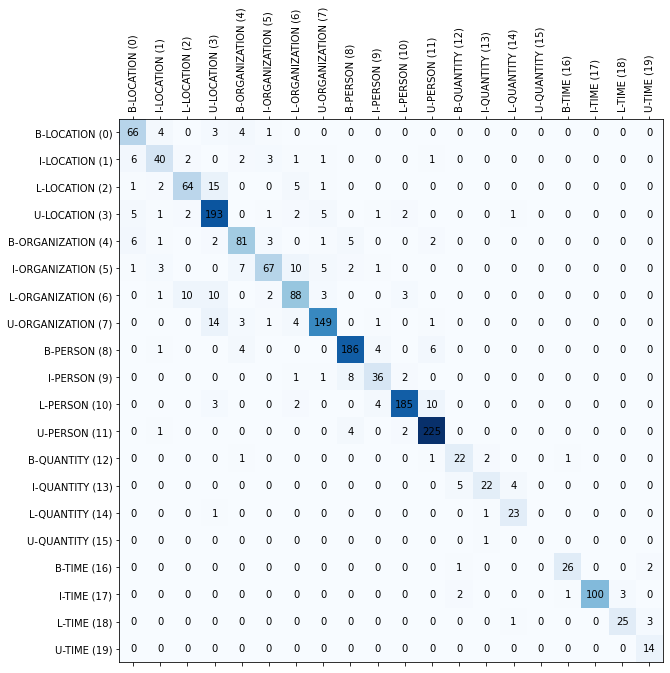

In [ ]:
get_report(bilstm_w2v, bilstm_w2v_history)

### BiLSTM-CNNs

In [ ]:
bilstm_cnns = create_model(params, cnn=True)

In [ ]:
bilstm_cnns.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 400)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 128)           153728    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 200)           183200    
_________________________________________________________________
dense_2 (Dense)              (None, 40, 21)            4221      
Total params: 5,553,549
Trainable params: 5,553,549
Non-trainable params: 0
_________________________________________________

In [ ]:
%%time

bilstm_cnns_history = bilstm_cnns.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 3s 126ms/step - loss: 1.0711 - f1_score_micro: 0.0019 - val_loss: 0.4523 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 3s 115ms/step - loss: 0.4372 - f1_score_micro: 0.0000e+00 - val_loss: 0.4040 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 3s 114ms/step - loss: 0.3835 - f1_score_micro: 0.0000e+00 - val_loss: 0.3692 - val_f1_score_micro: 0.0000e+00
Epoch 4/100
27/27 [==============================] - 3s 114ms/step - loss: 0.3328 - f1_score_micro: 3.4781e-04 - val_loss: 0.3293 - val_f1_score_micro: 0.0019
Epoch 5/100
27/27 [==============================] - 3s 116ms/step - loss: 0.2751 - f1_score_micro: 0.0849 - val_loss: 0.3009 - val_f1_score_micro: 0.1347
Epoch 6/100
27/27 [==============================] - 3s 115ms/step - loss: 0.2272 - f1_score_micro: 0.2455 - val_loss: 0.2750 - val_f1_score_micro: 0.2161
Epoch 7/100
27/27 [===========================

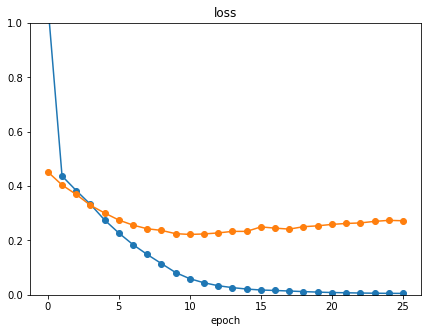

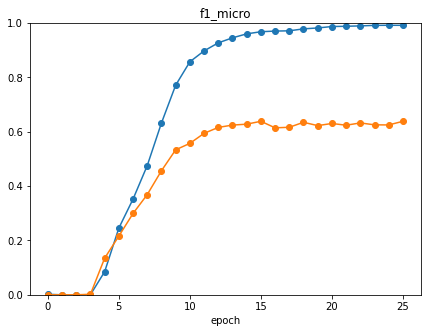


f1 score micro average include label O: 0.9539509536784742

                precision    recall  f1-score   support

    B-LOCATION       0.72      0.62      0.67       103
    I-LOCATION       0.46      0.34      0.39        77
    L-LOCATION       0.71      0.69      0.70       101
    U-LOCATION       0.77      0.67      0.72       235
B-ORGANIZATION       0.67      0.62      0.64       152
I-ORGANIZATION       0.73      0.48      0.58       138
L-ORGANIZATION       0.65      0.67      0.66       155
U-ORGANIZATION       0.80      0.70      0.75       248
      B-PERSON       0.83      0.65      0.73       224
      I-PERSON       0.66      0.58      0.62        60
      L-PERSON       0.84      0.64      0.72       225
      U-PERSON       0.84      0.81      0.82       257
    B-QUANTITY       0.24      0.38      0.29        58
    I-QUANTITY       0.29      0.46      0.36        52
    L-QUANTITY       0.26      0.51      0.35        53
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.621167576648467



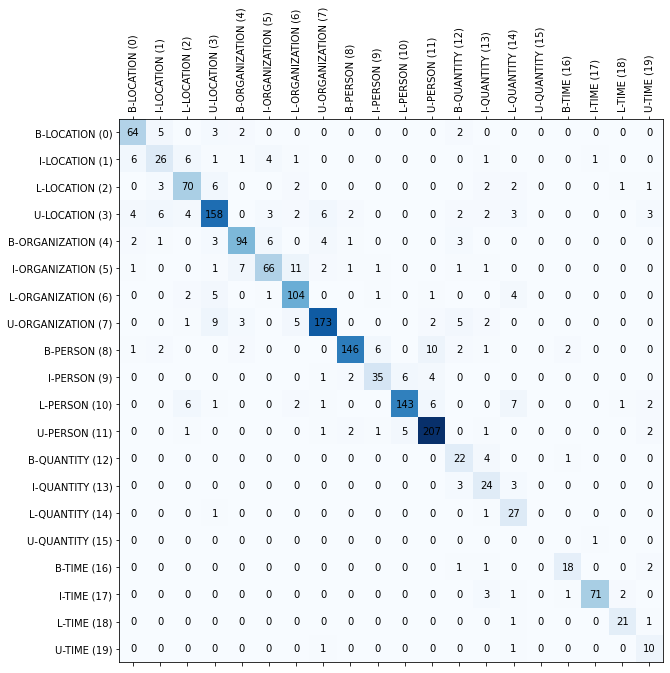

In [ ]:
get_report(bilstm_cnns, bilstm_cnns_history)

### BiLSTM-CNNs + w2v

In [ ]:
bilstm_cnns_w2v = create_model(params, w2v=True, cnn=True)

In [ ]:
bilstm_cnns_w2v.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 400)           5212400   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 40, 400)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40, 128)           153728    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 200)           183200    
_________________________________________________________________
dense_3 (Dense)              (None, 40, 21)            4221      
Total params: 5,553,549
Trainable params: 341,149
Non-trainable params: 5,212,400
___________________________________________

In [ ]:
%%time

bilstm_cnns_w2v_history = bilstm_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 1s 41ms/step - loss: 0.8224 - f1_score_micro: 0.0012 - val_loss: 0.4583 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 1s 41ms/step - loss: 0.4479 - f1_score_micro: 0.0000e+00 - val_loss: 0.4179 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 1s 41ms/step - loss: 0.4071 - f1_score_micro: 0.0032 - val_loss: 0.3813 - val_f1_score_micro: 0.0127
Epoch 4/100
27/27 [==============================] - 1s 42ms/step - loss: 0.3658 - f1_score_micro: 0.0124 - val_loss: 0.3404 - val_f1_score_micro: 0.0168
Epoch 5/100
27/27 [==============================] - 1s 40ms/step - loss: 0.3247 - f1_score_micro: 0.0370 - val_loss: 0.3066 - val_f1_score_micro: 0.0504
Epoch 6/100
27/27 [==============================] - 1s 40ms/step - loss: 0.2922 - f1_score_micro: 0.0881 - val_loss: 0.2817 - val_f1_score_micro: 0.1560
Epoch 7/100
27/27 [==============================] - 1s 40ms/ste

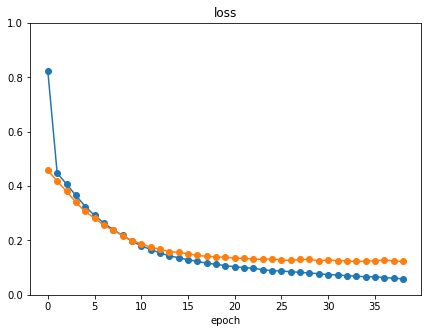

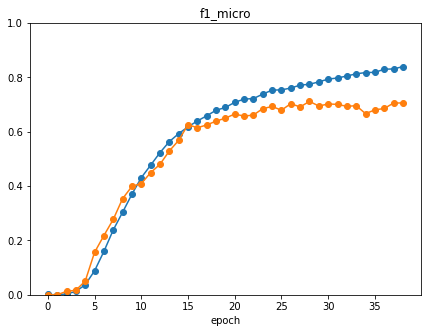


f1 score micro average include label O: 0.9628405994550409

                precision    recall  f1-score   support

    B-LOCATION       0.69      0.66      0.67       103
    I-LOCATION       0.56      0.53      0.55        77
    L-LOCATION       0.67      0.74      0.70       101
    U-LOCATION       0.81      0.77      0.79       235
B-ORGANIZATION       0.69      0.68      0.69       152
I-ORGANIZATION       0.53      0.56      0.55       138
L-ORGANIZATION       0.66      0.60      0.63       155
U-ORGANIZATION       0.72      0.66      0.69       248
      B-PERSON       0.86      0.86      0.86       224
      I-PERSON       0.54      0.73      0.62        60
      L-PERSON       0.85      0.85      0.85       225
      U-PERSON       0.86      0.84      0.85       257
    B-QUANTITY       0.54      0.34      0.42        58
    I-QUANTITY       0.50      0.31      0.38        52
    L-QUANTITY       0.49      0.34      0.40        53
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6963460730785385



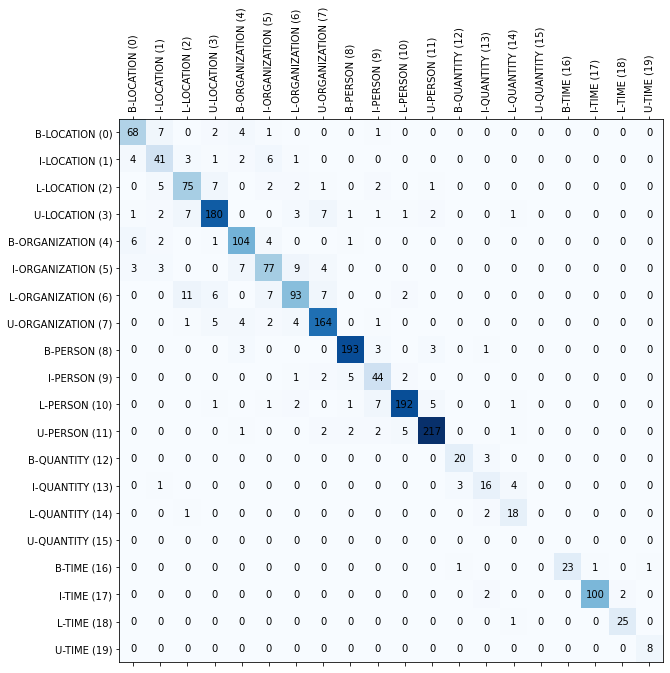

In [ ]:
get_report(bilstm_cnns_w2v, bilstm_cnns_w2v_history)

### BiLSTM-CNNs + multi-sequence n-gram

In [ ]:
multi_cnns_params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'filters': [128, 128, 128, 128, 128],
    'filter_size': [2, 4, 6, 8, 10],
    'dropout': 0.5,
    'batch_size': 128
}

In [ ]:
bilstm_multi_cnns = create_model(multi_cnns_params, cnn=True)

In [ ]:
bilstm_multi_cnns.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 400)      5212400     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_4 (SpatialDro (None, 40, 400)      0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 40, 128)      102528      spatial_dropout1d_4[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_history = bilstm_multi_cnns.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 5s 194ms/step - loss: 0.7702 - f1_score_micro: 0.0016 - val_loss: 0.4531 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 4s 138ms/step - loss: 0.4149 - f1_score_micro: 0.0000e+00 - val_loss: 0.3808 - val_f1_score_micro: 0.0000e+00
Epoch 3/100
27/27 [==============================] - 4s 138ms/step - loss: 0.3322 - f1_score_micro: 0.0095 - val_loss: 0.3050 - val_f1_score_micro: 0.0549
Epoch 4/100
27/27 [==============================] - 4s 141ms/step - loss: 0.2397 - f1_score_micro: 0.2160 - val_loss: 0.2596 - val_f1_score_micro: 0.2768
Epoch 5/100
27/27 [==============================] - 4s 137ms/step - loss: 0.1691 - f1_score_micro: 0.4489 - val_loss: 0.2219 - val_f1_score_micro: 0.4140
Epoch 6/100
27/27 [==============================] - 4s 137ms/step - loss: 0.1067 - f1_score_micro: 0.6839 - val_loss: 0.1999 - val_f1_score_micro: 0.5244
Epoch 7/100
27/27 [==============================] - 4s 13

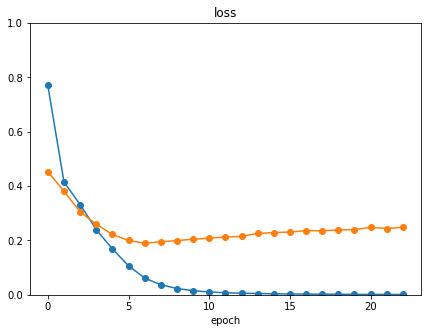

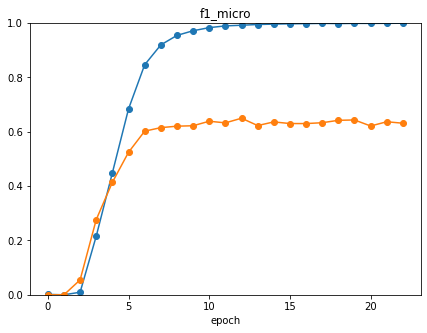


f1 score micro average include label O: 0.9604904632152589

                precision    recall  f1-score   support

    B-LOCATION       0.66      0.60      0.63       103
    I-LOCATION       0.50      0.42      0.45        77
    L-LOCATION       0.71      0.65      0.68       101
    U-LOCATION       0.78      0.71      0.74       235
B-ORGANIZATION       0.70      0.61      0.65       152
I-ORGANIZATION       0.70      0.54      0.61       138
L-ORGANIZATION       0.69      0.61      0.65       155
U-ORGANIZATION       0.82      0.76      0.79       248
      B-PERSON       0.89      0.67      0.77       224
      I-PERSON       0.74      0.65      0.69        60
      L-PERSON       0.89      0.64      0.75       225
      U-PERSON       0.84      0.82      0.83       257
    B-QUANTITY       0.39      0.34      0.37        58
    I-QUANTITY       0.52      0.42      0.47        52
    L-QUANTITY       0.37      0.47      0.42        53
    U-QUANTITY       0.00      0.00      0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6413271734565309



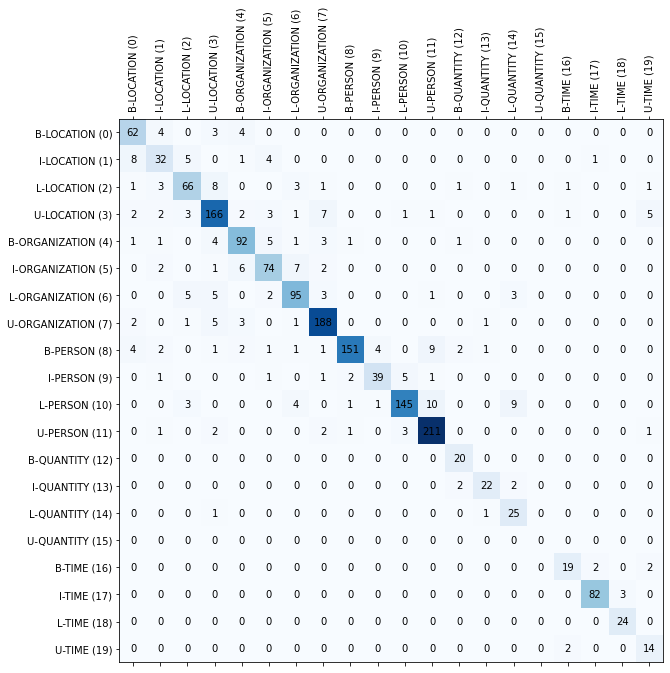

In [ ]:
get_report(bilstm_multi_cnns, bilstm_multi_cnns_history)

### BiLSTM-CNNs + multi-sequence n-gram + w2v

In [ ]:
bilstm_multi_cnns_w2v = create_model(multi_cnns_params, w2v=True, cnn=True)

In [ ]:
bilstm_multi_cnns_w2v.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 40, 400)      5212400     input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 40, 400)      0           embedding_5[0][0]                
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 40, 128)      102528      spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

In [ ]:
%%time

bilstm_multi_cnns_w2v_history = bilstm_multi_cnns_w2v.fit(
    x_train, np.array(y_train),
    validation_data=(x_val, np.array(y_val)),
    epochs=100, verbose=1, callbacks=[early_stopping], batch_size=multi_cnns_params['batch_size']
)

Epoch 1/100
27/27 [==============================] - 2s 60ms/step - loss: 0.5901 - f1_score_micro: 0.0015 - val_loss: 0.4105 - val_f1_score_micro: 0.0000e+00
Epoch 2/100
27/27 [==============================] - 2s 60ms/step - loss: 0.3924 - f1_score_micro: 0.0059 - val_loss: 0.3589 - val_f1_score_micro: 0.0012
Epoch 3/100
27/27 [==============================] - 2s 61ms/step - loss: 0.3315 - f1_score_micro: 0.0404 - val_loss: 0.3029 - val_f1_score_micro: 0.1021
Epoch 4/100
27/27 [==============================] - 2s 61ms/step - loss: 0.2780 - f1_score_micro: 0.1444 - val_loss: 0.2647 - val_f1_score_micro: 0.1877
Epoch 5/100
27/27 [==============================] - 2s 61ms/step - loss: 0.2389 - f1_score_micro: 0.2446 - val_loss: 0.2309 - val_f1_score_micro: 0.2890
Epoch 6/100
27/27 [==============================] - 2s 62ms/step - loss: 0.2079 - f1_score_micro: 0.3378 - val_loss: 0.2058 - val_f1_score_micro: 0.3643
Epoch 7/100
27/27 [==============================] - 2s 63ms/step - loss

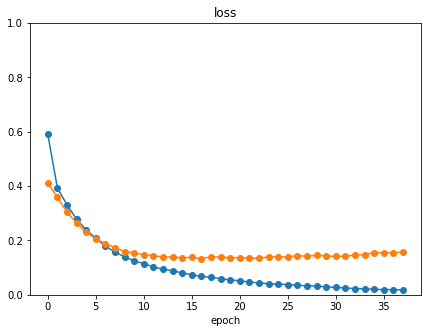

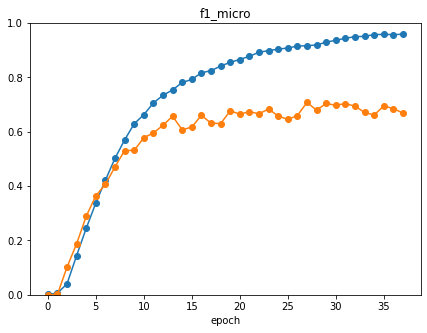


f1 score micro average include label O: 0.960933242506812

                precision    recall  f1-score   support

    B-LOCATION       0.64      0.63      0.63       103
    I-LOCATION       0.56      0.49      0.52        77
    L-LOCATION       0.63      0.72      0.68       101
    U-LOCATION       0.77      0.78      0.77       235
B-ORGANIZATION       0.62      0.55      0.58       152
I-ORGANIZATION       0.62      0.37      0.46       138
L-ORGANIZATION       0.70      0.57      0.63       155
U-ORGANIZATION       0.69      0.65      0.67       248
      B-PERSON       0.83      0.80      0.81       224
      I-PERSON       0.74      0.70      0.72        60
      L-PERSON       0.85      0.85      0.85       225
      U-PERSON       0.87      0.82      0.84       257
    B-QUANTITY       0.47      0.28      0.35        58
    I-QUANTITY       0.65      0.33      0.44        52
    L-QUANTITY       0.58      0.36      0.44        53
    U-QUANTITY       0.00      0.00      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


f1 score micro average without label O: 0.6606467870642587



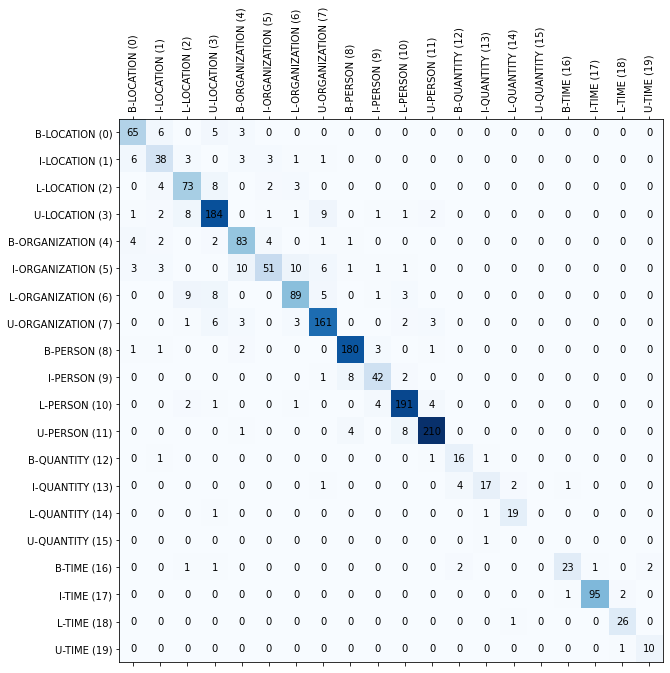

In [ ]:
get_report(bilstm_multi_cnns_w2v, bilstm_multi_cnns_w2v_history)